In [23]:
import torch
import torch.nn as nn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

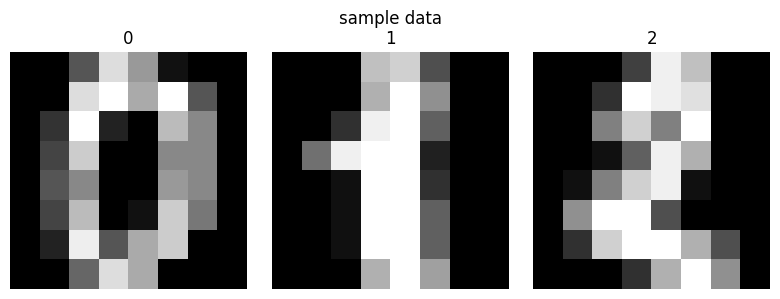

In [24]:
data_digits = load_digits()
fig,ax = plt.subplots(1,3)
fig.set_size_inches(8,3)
for i in range(3):  
    ax[i].imshow(data_digits.images[i], cmap='gray')
    ax[i].set_title(data_digits.target[i])
    ax[i].set_axis_off()
fig.suptitle("sample data")
plt.tight_layout()
plt.show()

##### Number distribution in dataset

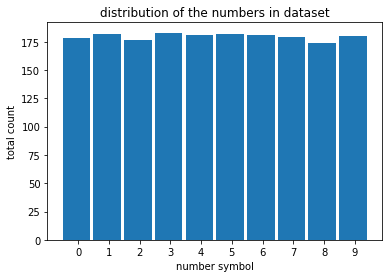

In [70]:
plt.hist(data_digits.target, bins=10, rwidth=0.9)#
plt.xticks([0.5 + (i)*9/10 for i in range(len(data_digits.target_names))],data_digits.target_names)
plt.xlabel("number symbol")
plt.ylabel("total count")
plt.title("distribution of the numbers in dataset")
plt.show()

## Model

In [29]:
from typing import Tuple
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3)
        self.conv2 = nn.Conv2d(6,24,3)
        self.pool1 = nn.MaxPool2d(2,2)
        self.flatten1 = nn.Flatten()
        self.flatten2 = nn.Flatten(-2, 1)
        self.FC1 = nn.Linear(96, 20)
        self.dropout1 = nn.Dropout(p=0.1)
        self.dropout2 = nn.Dropout(p=0.1)
        self.FC2 = nn.Linear(20,12)
        self.out = nn.Linear(12,10)
        self.model = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            self.conv2,
            nn.ReLU(),
            self.pool1,
            self.flatten1,
            self.flatten2,
            self.dropout1,
            self.FC1,
            nn.ReLU(),
            self.dropout2,
            self.FC2,
            nn.ReLU(),
            self.out,
            nn.Softmax(dim = -1)
        )

    def forward(self,input):
        return self.model(input)


In [72]:
x = torch.from_numpy(data_digits.images).type(torch.float)
y = torch.from_numpy(data_digits.target).type(torch.float)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=12)

In [73]:
model_0 = CNN()
with torch.inference_mode():
    pred = model_0(torch.reshape(xtrain[0], (1, 8, 8)))
    print(pred)

tensor([0.0799, 0.0837, 0.1211, 0.0917, 0.0964, 0.1300, 0.1056, 0.0814, 0.1244,
        0.0856])


In [74]:
from torch.optim import SGD
def train(model : CNN, nr_epoch, train_data, train_target, test_data, test_target, learning_rate = 1e-4):
    optimizer = SGD(model.parameters(), momentum=0.1, lr = learning_rate)
    loss_func = nn.CrossEntropyLoss()
    test_acc_hist = []
    train_acc_hist = []
    test_loss_hist = []
    train_loss_hist = []
    batch_size = 9
    optimizer.zero_grad()
    for epoch in range(nr_epoch):
        epoch_loss = 0.0
        epoch_accuracy = 0.0
        for t in range(len(train_data)):
            prediction = model(torch.reshape(train_data[t], (1, 8, 8)))
            target_value = torch.tensor([(0 if i != train_target[t] else 1) for i in range(10)],dtype=torch.float)
            loss_value = loss_func(prediction,target_value)
            loss_value.backward()
            if (t+1)%batch_size == 0:
                optimizer.step()
                optimizer.zero_grad()
            epoch_loss += loss_value.item()
            if torch.argmax(prediction) == train_target[t]:
                epoch_accuracy += 1
        epoch_test_loss = 0.0
        epoch_test_accuracy = 0.0
        with torch.inference_mode():
            for i in range(len(test_data)):
                prediction = model(torch.reshape(test_data[i], (1, 8, 8)))
                target_value = torch.tensor([(0 if j != test_target[i] else 1) for j in range(10)],dtype=torch.float)
                loss_value = loss_func(prediction,target_value)
                epoch_test_loss+=loss_value.item()
                if torch.argmax(prediction) == test_target[i]:
                    epoch_test_accuracy += 1
            
        
        print(f"""[{epoch}] avg loss: {epoch_loss/len(train_data)}, avg test loss: {epoch_test_loss/len(test_data)},
              train accuracy: {epoch_accuracy/len(train_data)}, test accuracy: {epoch_test_accuracy/len(test_data)}
              """)
        test_acc_hist.append(epoch_test_accuracy/len(test_data))
        train_acc_hist.append(epoch_accuracy/len(train_data))
        test_loss_hist.append(epoch_test_loss/len(test_data))
        train_loss_hist.append(epoch_loss/len(train_data))
    return test_acc_hist,train_acc_hist,test_loss_hist,train_loss_hist



In [75]:
test_acc_hist,train_acc_hist,test_loss_hist,train_loss_hist = train(model_0,70,xtrain,ytrain,xtest,ytest,learning_rate=0.003)


[0] avg loss: 2.3028690644080387, avg test loss: 2.303454013665517,
              train accuracy: 0.10786360473208072, test accuracy: 0.10833333333333334
              
[1] avg loss: 2.302422429757062, avg test loss: 2.3031848616070216,
              train accuracy: 0.10508002783576896, test accuracy: 0.09722222222222222
              
[2] avg loss: 2.302032573072132, avg test loss: 2.302615765068266,
              train accuracy: 0.10508002783576896, test accuracy: 0.1
              
[3] avg loss: 2.301284693311135, avg test loss: 2.3020725780063205,
              train accuracy: 0.10368823938761308, test accuracy: 0.09722222222222222
              
[4] avg loss: 2.3001797768334673, avg test loss: 2.300503228770362,
              train accuracy: 0.10368823938761308, test accuracy: 0.09444444444444444
              
[5] avg loss: 2.2978692034838843, avg test loss: 2.296891109810935,
              train accuracy: 0.1057759220598469, test accuracy: 0.10277777777777777
              
[6] 

## Validation

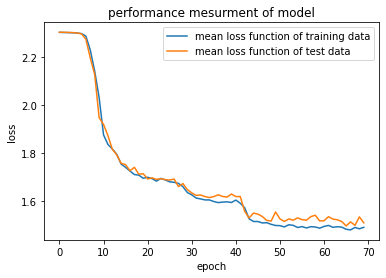

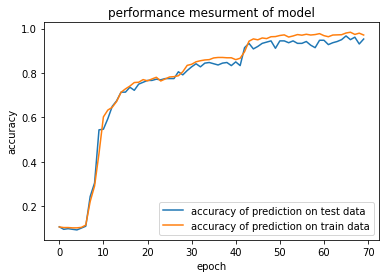

In [76]:
plt.plot(train_loss_hist,label="mean loss function of training data")
plt.plot(test_loss_hist, label="mean loss function of test data")
plt.legend()
plt.title("performance mesurment of model")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

plt.plot(test_acc_hist, label="accuracy of prediction on test data")
plt.plot(train_acc_hist, label="accuracy of prediction on train data")
plt.legend()
plt.title("performance mesurment of model")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [77]:
path = "./numbers_model.pth"
torch.save(model_0.state_dict(), path) 

## Validation of trained model

In [30]:
model = CNN()
model.load_state_dict(torch.load("./numbers_model.pth"))
model.eval()

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 24, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (flatten2): Flatten(start_dim=-2, end_dim=1)
  (FC1): Linear(in_features=96, out_features=20, bias=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
  (FC2): Linear(in_features=20, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=10, bias=True)
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 24, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Flatten(start_dim=-2, end_dim=1)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=96, out_features=20, bi

In [34]:
x = torch.from_numpy(data_digits.images).type(torch.float)
y = torch.from_numpy(data_digits.target).type(torch.float)
accuracy = 0.0
pred_list = []
for t in range(len(x)):
    prediction = model(torch.reshape(x[t], (1, 8, 8)))
    target_value = torch.tensor([(0 if i != y[t] else 1) for i in range(10)],dtype=torch.float)
    if torch.argmax(prediction) == y[t]:
        accuracy += 1
    pred_list.append(torch.argmax(prediction))
print(f"accuracy of the model on entire dataset = {accuracy/len(y)}")

accuracy of the model on entire dataset = 0.9905397885364496


##### Confusion matrix

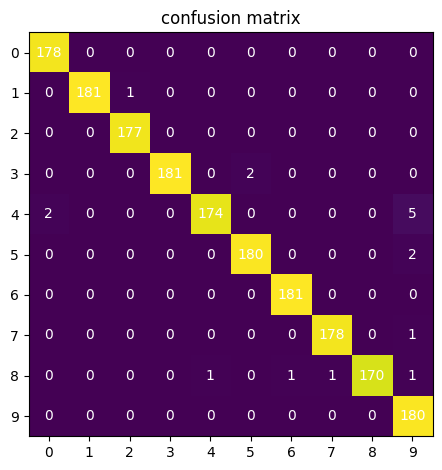

In [36]:
from sklearn.metrics import confusion_matrix

cf_mat = confusion_matrix(y, pred_list)
fig, ax = plt.subplots()
im = ax.imshow(cf_mat)
ax.set_title("confusion matrix")
ax.set_xticks(list(range(10)))
ax.set_yticks(list(range(10)))
for i in range(len(cf_mat)):
    for j in range(len(cf_mat[0])):
        ax.text(j, i, cf_mat[i, j], ha="center", va="center", color="w")
fig.tight_layout()
plt.show()

from confusion matrix we see that trained model has problems with differentation number 4 from 9 but overall for only 3 fully connected layers and two convolution layers it is acceptable score